# Отток клиентов

Банк стал замечать, что его клиенты постепенно уходят. Этот процесс происходит каждый месяц и, хоть и незначительно, но ощутимо влияет на общую картину. Маркетологи в банке провели анализ и пришли к выводу, что сохранение существующих клиентов обходится дешевле, чем привлечение новых.
Теперь требуется разработать модель прогнозирования, которая поможет определить, уйдет ли клиент из банка в ближайшее время или нет. Для этого предоставлены исторические данные о поведении клиентов и об их расторжении договоров с банком.

#### Шаги решения задачи:
1 Подготовка данных           
2 Исследование задачи       
3 Борьба с дисбалансом           
4 Обучение и тестирование модели

Моя задача состоит в построении модели с высоким значением F1-меры, которое должно быть равно или превышать 0.59, чтобы успешно выполнить проект. Кроме того, я должен проверить F1-меру на тестовой выборке.

Дополнительно, я буду измерять AUC-ROC и сравнивать его значение с F1-мерой.


## Подготовка данных

In [1]:
! pip install imblearn

     |████████████████████████████████| 226 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 16.8 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 87.8 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
! pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 2.6 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.1
    Uninstalling scikit-learn-1.2.1:
      Successfully uninstalled scikit-learn-1.2.1


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, roc_curve,
    roc_auc_score,
    recall_score,
    mean_squared_error
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from tqdm import tqdm
import re
import warnings
from sklearn.utils import shuffle

from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

In [4]:
try:
    data = pd.read_csv()

except:
    data = pd.read_csv()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in data.columns]

In [7]:
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Столбцы RowNumber, CustomerId, Surname не дадут никакой полезной информации для модели, поэтому удалим их

In [8]:
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [9]:
data.shape

(10000, 11)

In [10]:
data.duplicated().sum()

0

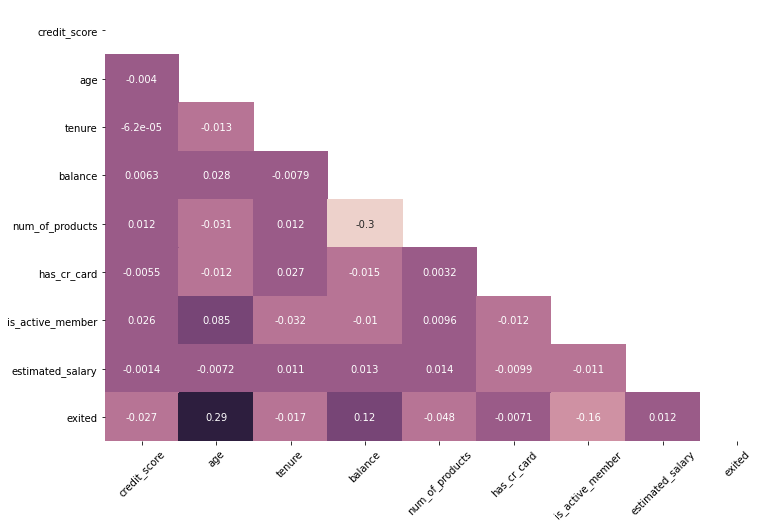

In [11]:
plt.rcParams['figure.figsize'] = (12,8)

# верхний треугольник корреляционной матриццы
matrix = np.triu(data.corr())

sns.heatmap(data.corr(), annot = True, cmap = sns.cubehelix_palette(8), cbar=False, mask=matrix)
plt.xticks(rotation=45);

Имеется слабая кореляция таргета с age. Так же слабая обратная корреляция между num_of_products и balance.  
Мультиколлинеарности не наблюдается. 

In [12]:
data.isna().sum()

credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

In [13]:
print('Пропущенных значений tenure: {:.2%}'.format(data['tenure'].isna()
                                           .sum()/data['tenure'].shape[0]))

Пропущенных значений tenure: 9.09%


In [14]:
data['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [15]:
data['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [16]:
data.describe(include='all')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000,10000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,650.528800,NaN,NaN,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,NaN,NaN,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,NaN,NaN,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


Аномалий и выбросов не наблюдаю

In [17]:
data.loc[data['tenure'].isna()].describe(include='all')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,909.000000,909,909,909.000000,0.0,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,464,483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,648.451045,NaN,NaN,38.647965,NaN,76117.341474,1.530253,0.710671,0.510451,99180.389373,0.201320
std,99.079381,NaN,NaN,9.785438,NaN,63105.690715,0.588452,0.453701,0.500166,56378.063765,0.401207
min,359.000000,NaN,NaN,18.000000,NaN,0.000000,1.000000,0.000000,0.000000,106.670000,0.000000
25%,580.000000,NaN,NaN,32.000000,NaN,0.000000,1.000000,0.000000,0.000000,49872.330000,0.000000
50%,647.000000,NaN,NaN,37.000000,NaN,96674.550000,1.000000,1.000000,1.000000,99444.020000,0.000000
75%,718.000000,NaN,NaN,43.000000,NaN,128554.980000,2.000000,1.000000,1.000000,145759.700000,0.000000


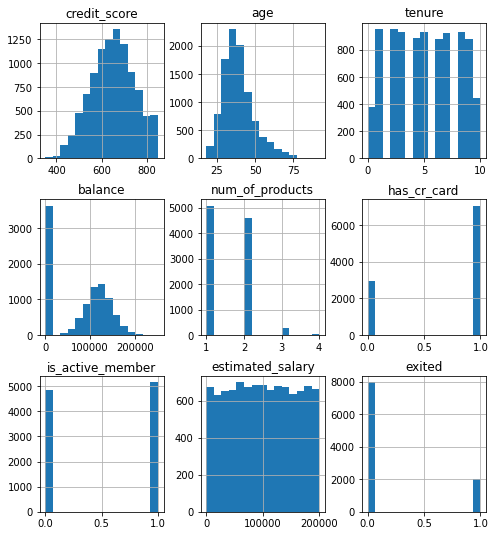

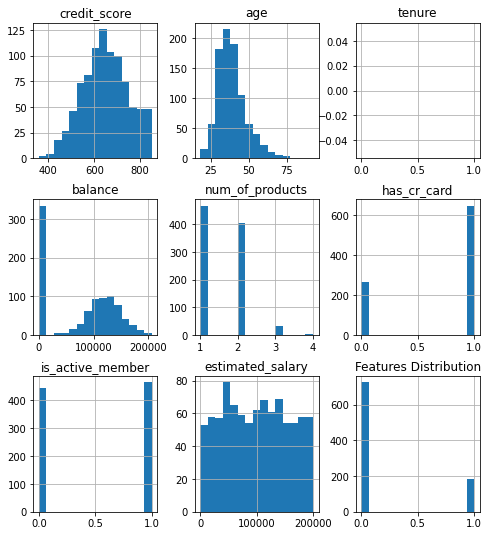

In [18]:
data.hist(figsize=(8,9),bins = 15)
data.loc[data['tenure'].isna()].hist(figsize=(8,9),bins = 15)
plt.title("Features Distribution")
plt.show()

Каритна одинакова для значений с пропусками и без пропусков в категории 'Tenure'. Значений 0 в этой категории совсем не много, что вызывает подозрения. Скорее всего, значения NaN сответствуют значению 0. Это можно проверить, сравнив точность моделей при замене NaN на 0, либо удалении NaN из датасета, либо замене на мединные значения.

In [19]:
data = data.fillna(data['tenure'].median())
#data = data.dropna()
#data = data.fillna(0)

In [20]:
data.isna().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [21]:
#Преобразовать категориальные не численные данные в численные методом OHE
#data_ohe = pd.get_dummies(data, drop_first=True) заменили на

#Заложить 60% на тренеровочную выборку
train_part, test_part = train_test_split(data, test_size=0.4, random_state=12345, stratify=data['exited'])

features_train = train_part.drop(['exited'], axis=1)
target_train = train_part['exited']

features_valid, features_test = train_test_split(test_part, test_size=0.5, random_state=12345, stratify=test_part['exited'])

target_valid = features_valid['exited']
features_valid = features_valid.drop(['exited'], axis=1)

target_test = features_test['exited']
features_test = features_test.drop(['exited'], axis=1)

In [22]:
print (features_train.shape, target_train.shape, target_valid.shape, features_valid.shape, target_test.shape, features_test.shape)

(6000, 10) (6000,) (2000,) (2000, 10) (2000,) (2000, 10)


In [23]:
features_train.head(3)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
2837,549,Germany,Female,49,6.0,124829.16,1,0,1,93551.36
9925,694,France,Female,38,5.0,195926.39,1,1,1,85522.84
8746,660,France,Male,34,8.0,106486.66,2,0,1,182262.66


In [24]:
#категориальные признаки для OHE Ridge
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

['geography', 'gender']


In [25]:
num_features = ['credit_score', 'tenure', 'age', 'balance', 'estimated_salary', 'num_of_products'] #features_train.select_dtypes(exclude='object').columns.to_list()

In [210]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[num_features] = scaler.fit_transform(features_train[num_features])

# смотрим на результат
features_train.head(3)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
2837,-1.040434,0.953312,0.360600,0.774657,-0.914708,0,1,-0.119110,1.0,0.0,0.0
9925,0.454006,-0.095244,-0.002786,1.910540,-0.914708,1,1,-0.258658,0.0,0.0,0.0
8746,0.103585,-0.476537,1.087371,0.481608,0.820981,0,1,1.422836,0.0,0.0,1.0


In [211]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем валидационную
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

features_valid = features_valid.drop(ohe_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
features_valid[num_features] = scaler.transform(
    features_valid[num_features]
)

# смотрим на результат
features_valid.head(3)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
6612,-1.524838,2.383160,-0.729557,1.011655,-0.914708,0,1,0.010275,0.0,0.0,0.0
519,0.587990,1.811221,0.360600,0.213192,-0.914708,0,1,0.453089,0.0,0.0,1.0
1609,-0.318980,-0.381213,1.087371,0.893896,-0.914708,1,0,-0.603508,0.0,0.0,0.0


In [212]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
features_test[num_features] = scaler.transform(
    features_test[num_features]
)

# смотрим на результат
features_test.head(3)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
657,-0.504497,1.429928,-1.456328,0.873883,0.820981,1,1,1.725255,1.0,0.0,0.0
2083,-1.195031,-1.429769,-1.456328,-1.219673,-0.914708,1,1,1.203665,0.0,0.0,1.0
3234,-1.267176,0.762665,-1.456328,-1.219673,-0.914708,1,0,-1.374743,0.0,0.0,1.0


#### Вывод по предобработке:

Не удалось вывести закономерность появления пропусков, поэтому значения NaN в столбце tenure были заменены на медиану

Для выборки train, преобразовали категориальные данные в численные с помощью OneHotEncoder. 
Количественные данные стандартизировали с помощью StandardScaler.   
Эти параметры, перенесли на valid и test выборки

## Исследование задачи

Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.

In [214]:
target_train.value_counts()

0    4778
1    1222
Name: exited, dtype: int64

In [216]:
best_model_rf = None
best_result = 0
count_i = 0 

for max_depth in list(np.arange(5, 15, step=1)):
    for est in np.arange(40, 70, step=1):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = max_depth, n_jobs=-1) # обучите модель с заданным количеством деревьев
        model_forest.fit(features_train, target_train) # обучите модель на тренировочной выборке
        predicted_valid = model_forest.predict(features_valid) # получите предсказания модели
        result = f1_score(target_valid, predicted_valid) # посчитайте качество модели
        count_i += 1
        if result > best_result:
            best_max_depth = max_depth
            best_result = result
            best_est = est
            best_model_rf = model_forest

print("F1 наилучшей модели на валидационной выборке:", best_result, 'лучший реультат при n_estimators =', best_est, 'max_depth =', best_max_depth)

F1 наилучшей модели на валидационной выборке: 0.6146926536731634 лучший реультат при n_estimators = 42 max_depth = 11


In [217]:
model_logistic = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_logistic.fit(features_train, target_train)
predictions_logistic = model_logistic.predict(features_valid) # получите предсказания модели
print('F1 мера =', f1_score(target_valid, predictions_logistic))

F1 мера = 0.30458715596330277


Вывод:

Классы не сбаллансированы, но F1 мера модели случайного леса преодолела порог 0.59. F1 для логистической регрессии равна 0.30458715596330277, что указывает на низкое качество модели
На следующем шаге проведем балансировку и подберем лучшие параметры для моделей.

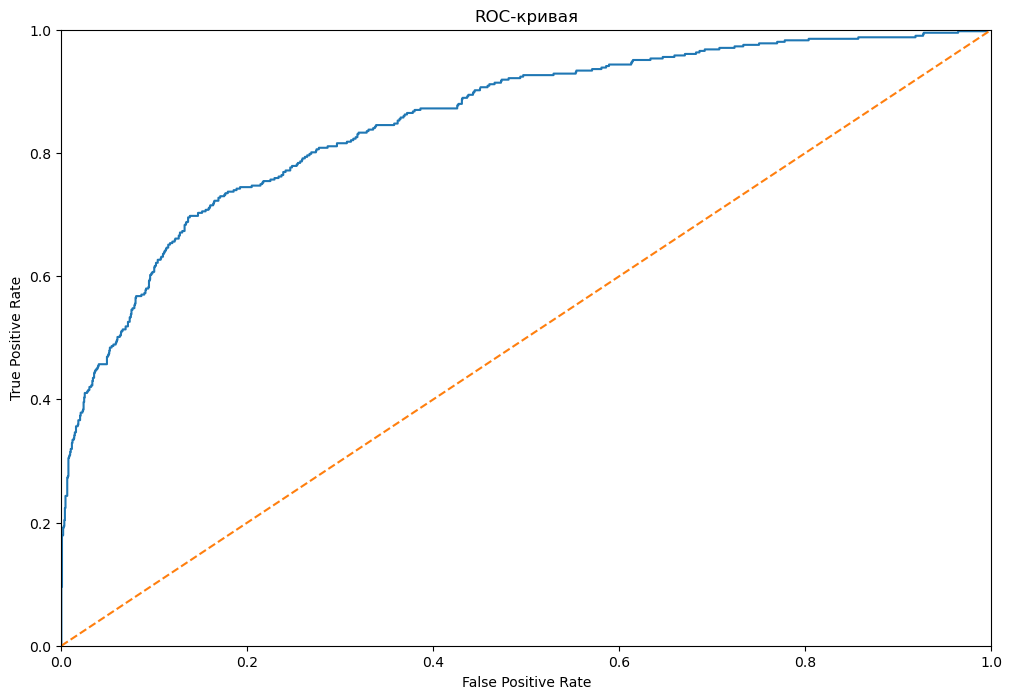

Площадь ROC-кривой: 0.85228525906492


In [218]:
#Построим ROC Кривую
probabilities_test = best_model_rf.predict_proba(features_test)
probabilities_one_valid = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1]) 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()
print('Площадь ROC-кривой:', roc_auc_score(target_test, probabilities_one_valid))

Метрика лучше, чем у случайной модели, но до единицы далеко

## Борьба с дисбалансом

#### Опробуем метод взвешивания классов

In [219]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5289982425307558


In [220]:
best_model_rf = None
best_result = 0
#max_depth = 0
count_i = 0 

for max_depth in list(np.arange(5, 15, step=1)):
    for est in np.arange(40, 70, step=1):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = max_depth, n_jobs=-1, class_weight='balanced') # обучите модель с заданным количеством деревьев
        model_forest.fit(features_train, target_train) # обучите модель на тренировочной выборке
        predicted_valid = model_forest.predict(features_valid) # получите предсказания модели
        result = f1_score(target_valid, predicted_valid) # посчитайте качество модели
        count_i += 1
        if result > best_result:
            best_max_depth = max_depth
            best_model_rf = model_forest
            best_result = result
            best_est = est

print("F1 наилучшей модели на валидационной выборке:", best_result, 'лучший реультат при n_estimators =', best_est, 'max_depth =', best_max_depth)

F1 наилучшей модели на валидационной выборке: 0.6578313253012048 лучший реультат при n_estimators = 65 max_depth = 10


#### Опробуем метод уменьшения выборки

In [221]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [222]:
rat = np.round(np.sum(target_train == 1)/np.sum(target_train == 0),1)

features_downsampled, target_downsampled = downsample(features_train, target_train, rat)

In [223]:
target_downsampled.value_counts()

0    1433
1    1222
Name: exited, dtype: int64

In [224]:


model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5350795135640786


In [225]:
best_model_rf = None
best_result = 0
#max_depth = 0
count_i = 0 

for max_depth in list(np.arange(5, 15, step=1)):
    for est in np.arange(40, 70, step=1):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = max_depth, n_jobs=-1) # обучите модель с заданным количеством деревьев
        model_forest.fit(features_downsampled, target_downsampled) # обучите модель на тренировочной выборке
        predicted_valid = model_forest.predict(features_valid) # получите предсказания модели
        result = f1_score(target_valid, predicted_valid) # посчитайте качество модели
        count_i += 1
        if result > best_result:
            best_max_depth = max_depth
            best_model_rf = model_forest
            best_result = result
            best_est = est

print("F1 наилучшей модели на валидационной выборке:", best_result, 'лучший реультат при n_estimators =', best_est, 'max_depth =', best_max_depth)

F1 наилучшей модели на валидационной выборке: 0.646379853095488 лучший реультат при n_estimators = 66 max_depth = 7


#### Опробуем метод увеличения выборки

In [228]:
oversample = SMOTE(random_state=12345)

features_train_upsampled, target_train_upsampled = oversample.fit_resample(features_train, target_train)

In [229]:
target_train_upsampled.value_counts()

0    4778
1    4778
Name: exited, dtype: int64

In [230]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5101500441306266


In [231]:
best_model_rf = None
best_result = 0
#max_depth = 0
count_i = 0 

for max_depth in list(np.arange(5, 15, step=1)):
    for est in np.arange(40, 70, step=1):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = max_depth, n_jobs=-1) # обучите модель с заданным количеством деревьев
        model_forest.fit(features_train_upsampled, target_train_upsampled) # обучите модель на тренировочной выборке
        predicted_valid = model_forest.predict(features_valid) # получите предсказания модели
        result = f1_score(target_valid, predicted_valid) # посчитайте качество модели
        count_i += 1
        if result > best_result:
            best_max_depth = max_depth
            best_model_rf = model_forest
            best_result = result
            best_est = est

print("F1 наилучшей модели на валидационной выборке:", best_result, 'лучший реультат при n_estimators =', best_est, 'max_depth =', best_max_depth)

F1 наилучшей модели на валидационной выборке: 0.6454545454545454 лучший реультат при n_estimators = 68 max_depth = 9


F1 наилучшей модели на валидационной выборке: 0.6578313253012048 лучший реультат при n_estimators = 65 max_depth = 10

RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = max_depth, n_jobs=-1, class_weight='balanced')

In [238]:
#дообучим модель на валидацционной выборке
features_train_valid = pd.concat([features_train, features_valid], ignore_index=True)
target_train_valid = pd.concat([target_train, target_valid], ignore_index=True)
display(features_train_valid.shape, target_train_valid.shape)
model_forest_selected = RandomForestClassifier(random_state=12345, n_estimators=65, max_depth = 10, n_jobs=-1, class_weight='balanced')
model_forest_selected.fit(features_train_valid, target_train_valid)

(8000, 11)

(8000,)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=65,
                       n_jobs=-1, random_state=12345)

#### Выводы: 
При балансировке классов удалось подтянуть F1 для логистической регрессии, но она все еще далеко от порога в 0.59.        
Лучший резутьтат показала модель случайного леса, при взвешивании классов

## Тестирование модели

In [239]:
predicted_test = model_forest_selected.predict(features_test) # получите предсказания модели
print('F1 на тестовой выборке = ', f1_score(target_test, predicted_test))

F1 на тестовой выборке =  0.6109785202863962


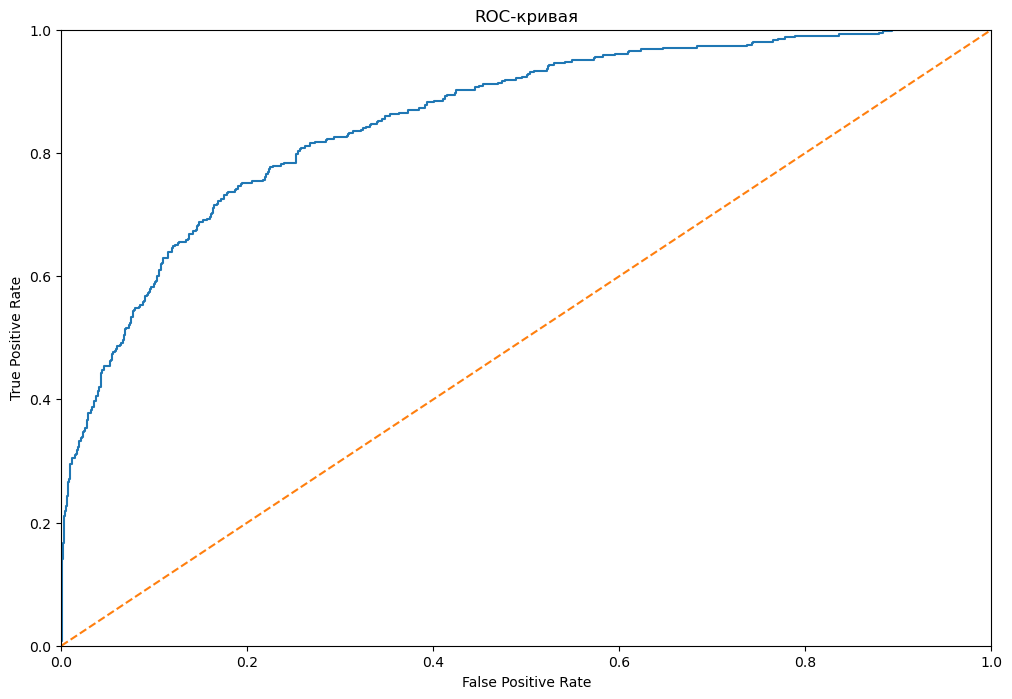

auc_roc = 0.855953025444551


In [234]:
#Построим ROC Кривую
probabilities_test = model_forest_selected.predict_proba(features_test)
probabilities_one_valid = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1]) 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()
print('auc_roc =', roc_auc_score(target_test, probabilities_one_valid))

Метрика лучше, чем у случайной модели, но до единицы далеко

In [235]:
print('Recall =', recall_score(target_test, predicted_test))

Recall = 0.628992628992629


## Выводы
После проведения анализа, выяснилось, что лучшей моделью в данном проекте является модель случайного леса. Она показала наивысшую F1-меру среди всех моделей, которыми мы проводили эксперименты. С другой стороны, логистическая регрессия показала наихудшие результаты и не достигла требуемого значения F1=0.59.

Наша модель позволяет предсказывать уход клиента из банка в 63% случаев, что на 13% превышает результаты константной модели. Перед применением балансировки классов, модель случайного леса достигла F1-меры равной 0.6146926536731634. Затем мы провели сравнение трех различных методов балансировки классов: взвешивание выборки, увеличение классов и уменьшение классов. Наилучший результат по F1-мере показал метод взвешивания классов. На валидационной выборке достигнута F1-мера 0.6578313253012048. Однако, на тестовой выборке F1-мера составила 0.6109785202863962, существенно уступая результату на валидационной выборке. Тем не менее, удалось преодолеть требуемый барьер в 0.59. После дообучения модели на валидационной выборке, метрика F1 увеличилась примерно на 0.02.

Метрика AUC-ROC также немного улучшилась после проведения балансировки классов и составила 0.86. В сравнении с константной моделью, чья метрика равна 0.5, наша модель показывает гораздо более высокие результаты, что свидетельствует о ее хорошей предсказательной способности.